In [724]:

import numpy as np

import matplotlib.pyplot as plt
import tensorflow as tf
from collections import Counter
import random
import bisect

In [725]:
link = 'https://storage.googleapis.com/tensorflow/tf-keras-datasets/mnist.npz'
path = tf.keras.utils.get_file('mnist.npz', link)    
DATASET = np.load(path)
x_train, y_train = DATASET['x_train'], DATASET['y_train']
x_test, y_test = DATASET['x_test'], DATASET['y_test']

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


Use https://storage.googleapis.com/tensorflow/tf-keras-datasets/mnist.npz MNIST
dataset for this question and select two digits - 0 and 1. Label them as -1 and
1. In this exercise you will be implementing AdaBoost.M1. Perform following
tasks.

In [726]:
train_selective = np.isin(y_train , [0,1]) 
test_selective = np.isin(y_test , [0,1])

x_train ,y_train = x_train[train_selective], y_train[train_selective]
x_test , y_test = x_test[test_selective], y_test[test_selective]


print(x_train.shape)
print(y_train.shape)
# print(y_train[3])

y_train_new = np.where(y_train == 0, -1, 1)
y_train = y_train_new 

y_test_new = np.where(y_test == 0 ,-1, 1)
y_test = y_test_new 
print(y_train.shape)

(12665, 28, 28)
(12665,)
(12665,)


Divide the train set into train and val set. Keep 1000 samples from each
class for val. Note val should be used to evaluate the performance of the
classifier. Must not be used in obtaining PCA matrix.

In [727]:
x_train_set = [] 
x_val_set = []
y_train_set = []
y_val_set = []

total_taken = [0]*(2) 
for i in range(len(x_train)):
  if (y_train[i] == -1 and (total_taken[0] < 1000) ):
    x_val_set.append(x_train[i]) 
    y_val_set.append(y_train[i])
    total_taken[0] += 1 
  elif (y_train[i] == 1 and (total_taken[1] < 1000)):
    x_val_set.append(x_train[i]) 
    y_val_set.append(y_train[i])
    total_taken[1] += 1
  else:
    x_train_set.append(x_train[i])
    y_train_set.append(y_train[i])

x_train_set = np.array(x_train_set)
x_val_set = np.array(x_val_set)
y_train_set = np.array(y_train_set)
y_val_set = np.array(y_val_set)
  
print(x_train_set.shape)
print(x_val_set.shape)
print(y_train_set.shape)
print(y_val_set.shape)

# thus we have created a val set of 2000 samples with 1000 samples of each class each ie . -1 and 1 
 


(10665, 28, 28)
(2000, 28, 28)
(10665,)
(2000,)


In [728]:
# Now lets reduce the dimensions of the train set .
x_train_set = x_train_set.reshape(x_train_set.shape[0] , -1) 
x_val_set = x_val_set.reshape(x_val_set.shape[0] ,  -1)
x_test = x_test.reshape(x_test.shape[0] ,  -1)

x_train_set = x_train_set.T
x_val_set = x_val_set.T
x_test = x_test.T


print(x_train_set.shape)
print(x_val_set.shape)

# changing the dimension of the train set first 
X = x_train_set
mean_X_set = np.mean(X, axis=1, keepdims=True)
print(mean_X_set.shape)

X_centered = X - mean_X_set

S = (X_centered @ np.transpose(X_centered)) / (X_centered.shape[1] - 1) 

eigenvalues, eigenvectors = np.linalg.eig(S)
sorted_indices_set = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_indices_set]
eigenvectors_set = eigenvectors[:, sorted_indices_set]

U = eigenvectors_set
p = 5

x_train_set = np.transpose(U[:, :p]) @ X_centered


print(x_train_set.shape)
x_train_set = x_train_set.T 

# Now we will change the dimensions of the val test also  . 

X = x_val_set
mean_X = np.mean(x_val_set, axis=1, keepdims=True)
print(mean_X.shape)

X_centered = X - mean_X

S = (X_centered @ np.transpose(X_centered)) / (X_centered.shape[1] - 1) 

eigenvalues, eigenvectors = np.linalg.eig(S)
sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]

U = eigenvectors
p = 5

x_val_set = np.transpose(U[:, :p]) @ X_centered


print(x_val_set.shape)
x_val_set = x_val_set.T 

# applying pca on the test set . 

X = x_test
mean_X = np.mean(x_test, axis=1, keepdims=True)
print(mean_X_set.shape)
X_centered = x_test - mean_X_set

S = (X_centered @ np.transpose(X_centered)) / (X_centered.shape[1] - 1) 

eigenvalues, eigenvectors = np.linalg.eig(S)
sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]

U = eigenvectors_set  
p = 5

x_test = np.transpose(U[:, :p]) @ X_centered


print(x_test.shape)
x_test = x_test.T 




unique_Values = [np.unique(x_train_set[:, i]) for i in range(p)]

 


(784, 10665)
(784, 2000)
(784, 1)
(5, 10665)
(784, 1)
(5, 2000)
(784, 1)
(5, 2115)


In [729]:
print(unique_Values[0])

[-2330.82976086+0.j -2327.20344266+0.j -2290.15016654+0.j ...
  1128.97522928+0.j  1138.47192104+0.j  1139.9026577 +0.j]


Now learn a decision tree using the train set. You need to grow a deci-
sion stump. For each dimension, find the unique values and sort them

in ascending order. The splits to be evaluated will be midpoint of two
consecutive unique values. Find the best split by minimizing weighted
miss-classification error. Denote this as h1(x). Note as we are dealing
with real numbers, each value may be unique. So just sorting them and
taking midpoint of consecutive values may also result in similar tree.

Compute α1 and update weights.
• Now build another tree h2(x) using the train set but with updated weights.
Compute α2 and update weights. Similarly grow 300 such stumps.
• After every iteration find the accuracy on val set and report. You should
show a plot of accuracy on val set vs. number of trees. Use the tree that
gives highest accuracy and evaluate that tree on test set. Report test
accuracy.

9.376465072667604e-05
0.004688232536333803
[0]
[(192.72278407732898+0j)]
this is the accuracy 0.995
0.01990623534927332
0.24363727945600314
[0, 0]
[(192.72278407732898+0j), (637.0513407899202+0j)]
this is the accuracy 0.995
0.061798154856200375
0.19133761691827686
[0, 0, 0]
[(192.72278407732898+0j), (637.0513407899202+0j), (-294.5555128102517+0j)]
this is the accuracy 0.995
0.061798154856200375
0.2606771628395517
[0, 0, 0, 3]
[(192.72278407732898+0j), (637.0513407899202+0j), (-294.5555128102517+0j), (143.17280626729058+0j)]
this is the accuracy 0.995
0.061798154856200375
0.284860067708763
[0, 0, 0, 3, 1]
[(192.72278407732898+0j), (637.0513407899202+0j), (-294.5555128102517+0j), (143.17280626729058+0j), (-250.31741539273094+0j)]
this is the accuracy 0.995


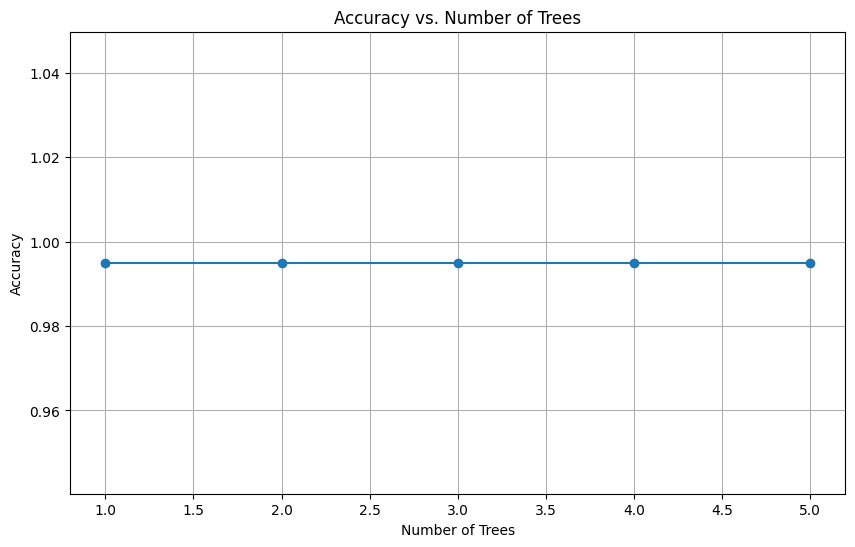

0.995
4


In [730]:
weights = [1/(len(x_train_set))]*(len(x_train_set))
weights = np.array(weights)
# storing the information of the classifiers in arrays the split value and the dimension chosen for the decision stumps 
dimension_chosen_array = []  ; split_chosen_array = [] ; left_val_array = [] ; right_val_array = [] ; alpha_value = [] ; losses_array = [] ; accuracy_list = []
# print(weights)

def calculate_loss_function(x_train_set, y_train_set, weights, dimension, split_value, sorted_indices, indx):
   
    class1 = y_train_set[:indx]  ; class2 = y_train_set[indx:]
    weight1 = weights[:indx]  ; weight2 = weights[indx: ]
    if (np.sum(class1) > 0 ):
      decision_class_left = 1 
    else:
      decision_class_left = -1 
    if (np.sum(class2) > 0 ):
      decision_class_right = 1 
    else:
      decision_class_right = -1 
    
    error_class1 = weight1[class1 != decision_class_left]
    error_class2 = weight2[class2 != decision_class_right]

    ans = np.sum(error_class1) + np.sum(error_class2)
    ans /= (np.sum(weights))
    return ans,  decision_class_left, decision_class_right


  




  
def minimum_each_dimension(x_train_set, y_train_set , weights , dimension):
  unique_values = unique_Values[dimension]
  
  # unique_values = np.random.choice(unique_values , size=1000 , replace=False)
  
#   unique_values = np.unique(x_train_set[:, dimension])
#   # for x in x_train_set:
#   #   if (x[dimension] not in unique_values):
#   #     unique_values.append(x[dimension])
  
#   unique_values = sorted(unique_values) 
  sorted_indices = np.argsort(x_train_set[:, dimension])
  # print(sorted_indices)
  x_train_set_sorted = x_train_set[sorted_indices]
  y_train_set_sorted = y_train_set[sorted_indices]
  
  weights_sorted = weights[sorted_indices]

  loss_val = 1.1  
  split_val = 0   
  wrongly_classified_points = []
  decided_class_left = 0 
  decided_class_right = 0 
  
  midpoints = (unique_values[1:] + unique_values[:-1]) /2 
  for i in range(len(midpoints) ):
    split_value = midpoints[i]
    # print("h1 : "+ str(split_value))
    loss_at_split , decided_class_left_new , decided_class_right_new = calculate_loss_function(x_train_set_sorted , y_train_set_sorted , weights_sorted , dimension , split_value ,sorted_indices , i)

    if (loss_val > loss_at_split):
      split_val = split_value 
      loss_val = loss_at_split  
      decided_class_left = decided_class_left_new  
      decided_class_right = decided_class_right_new 
  
  return loss_val , split_val , decided_class_left , decided_class_right

  
def best_dimension_and_split(x_train_set, y_train_set , weights):
  loss_val = 1.1 ; split_val = 0 ; selected_dimension = -1 ; wrongly_classified_points = [] ; decided_class_left =0 ; decided_class_right = 0
  # print(len(x_train_set))
  for x in range(len(x_train_set[1])):
    
    loss_value , split_value  , decided_class_left_new ,decided_class_right_new = minimum_each_dimension(x_train_set  , y_train_set , weights , x) 
    if (loss_val > loss_value):
      loss_val = loss_value 
      split_val = split_value 
      selected_dimension = x
      decided_class_left = decided_class_left_new 
      decided_class_right = decided_class_right_new 
    # print(loss_value , split_value , wrongly_classified_points) 

  # print(len(wrongly_classified_points))
  return selected_dimension , split_val , loss_val , decided_class_left , decided_class_right

def change_weights(sorted_x_train_set , sorted_y_train_set , sorted_weights , split_val , loss_val):
  indices_to_include = sorted_x_train_set <= split_val  
  y_left = sorted_y_train_set[indices_to_include]
  indices_to_include = sorted_x_train_set > split_val  
  y_right = sorted_y_train_set[indices_to_include] 
  indices_to_include = sorted_x_train_set <= split_val  
  weights_left = sorted_weights[indices_to_include] 
  indices_to_include = sorted_x_train_set > split_val  
  weights_right = sorted_weights[indices_to_include]
  if (np.sum(y_left) > 0 ):
    decision_left = 1  
  else:
    decision_left = -1 
  if (np.sum(y_right) > 0 ):
    decision_right = 1 
  else:
    decision_right = -1  

  update_left = y_left != decision_left
  update_right = y_right != decision_right
  weights_left[update_left] *= (1-loss_val)/(loss_val)
  weights_right[update_right] *= (1-loss_val)/(loss_val)

  weights_new =  np.concatenate((weights_left , weights_right))
  return weights_new

def find_accuracy(indx , x_set , y_set):
  ans = 0  
  for i in range(len(x_set)):
    count1 = 0 
    for j in range(0 , indx+1):
      if (x_set[i][dimension_chosen_array[j]] < split_chosen_array[j]):
        count1 += (alpha_value[j] * left_val_array[j]) 
      else:
        count1 += (alpha_value[j] * right_val_array[j]) 
    

    if (np.sign(count1) == y_set[i]):
      ans +=1 
  
  return ans/(len(x_set))


max_value_trees = -1 
max_accuracy = -1
# now let me create the h1(x) from the information provided by the above functions , it is just conditionals . 
def create_classifiers(x_train_set , y_train_set, weights , num_of_classifiers , max_value_trees , max_accuracy ):


  for num in range(0 , num_of_classifiers):
    print(weights[11])
    selected_dimension , split_val , loss_val  , decided_class_left , decided_class_right = best_dimension_and_split(x_train_set , y_train_set , weights) 

    dimension_chosen_array.append(selected_dimension)
    split_chosen_array.append(split_val)
    left_val_array.append(decided_class_left) 
    right_val_array.append(decided_class_right)
    print(loss_val)
    losses_array.append(loss_val)
    alpha = np.log((1-loss_val) / (loss_val)) 
    alpha_value.append(alpha) 

    sorted_x_indices = np.argsort(x_train_set[:,selected_dimension])
    sorted_x_train_set = x_train_set[sorted_x_indices , selected_dimension] 
    sorted_y_train_set = y_train_set[sorted_x_indices]
    indices_to_take = sorted_x_train_set <= split_val
    indices_to_take = sorted_x_train_set > split_val
    sorted_weights = weights[sorted_x_indices]

    new_weights = change_weights(sorted_x_train_set , sorted_y_train_set , sorted_weights , split_val , loss_val)

    old_indx = np.argsort(sorted_x_indices)
    weights = new_weights[old_indx]

  
    
    print(dimension_chosen_array)
    print(split_chosen_array)
    # print(alpha)  
    # print(losses_array)
    # print(left_val_array)
    # print(right_val_array)
    # print(weights[11])
    accuracy = find_accuracy(num , x_val_set , y_val_set)
    print("this is the accuracy " + str(accuracy))
    accuracy_list.append(accuracy)

    if (max_accuracy <= accuracy):
      max_accuracy = accuracy 
      max_value_trees = num 

    
  
  num_trees = range(1, len(accuracy_list) + 1)

  plt.figure(figsize=(10, 6))
  plt.plot(num_trees, accuracy_list, marker='o')
  plt.xlabel('Number of Trees')
  plt.ylabel('Accuracy')
  plt.title('Accuracy vs. Number of Trees')
  plt.grid(True)
  plt.show()

  # now ,lets test the accuracy on the test set . 
  print(max_accuracy) 
  print(max_value_trees)

  return max_accuracy , max_value_trees 


# print(len(x_train_set))
# print(minimum_each_dimension(x_train_set , y_train_set , weights , 0))
# print(x_train_set.shape)
# print(best_dimension_and_split(x_train_set , y_train_set , weights))
max_accuracy , max_value_trees = (create_classifiers(x_train_set , y_train_set ,weights, 5 , max_value_trees , max_accuracy))
# def find_best_split(x_train_set , y_train_set , weights):w

In [731]:
print(max_accuracy) 
print(max_value_trees)
test_accuracy = find_accuracy(max_value_trees , x_test , y_test)

print("The accuracy for the test set is :" + str(test_accuracy * 100) +" %") 

0.995
4
The accuracy for the test set is :99.62174940898345 %


Q2: Consider the above as a regression problem. Apply gradient boosting
using absolute loss and report the MSE between predicted and actual values of
test set.

Divide the train set into train and val set. Keep 1000 samples from each
class for val. Note val should be used to evaluate the performance of the
classifier. Must not be used in obtaining PCA matrix.
Apply PCA and reduce the dimension to p = 5. You can use the train set
of the two classes to obtain PCA matrix. For the remaining parts, use the
reduced dimension dataset.

We already did these steps in the first question , so we have the train , val and test sets . 

Now learn a decision tree using the train set. You need to grow a deci-
sion stump. For each dimension, find the unique values and sort them

in ascending order. The splits to be evaluated will be midpoint of two
consecutive unique values. Find the best split by minimizing SSR. Denote
this as h1(x). 
• Compute residue using y − .01h1(x).
• Now build another tree h2(x) using the train set but with updated labels.
Note, now you have to update labels based on the way we update labels
for absolute loss. That is the labels will be obtained as negative gradients.
Compute residue using y − .01h1(x) − .01h2(x).

• Similarly grow 300 such stumps. Note, the labels are updated every iter-
ation based on negative gradients.

• After every iteration find the MSE on val set and report. You should
show a plot of MSE on val set vs. number of trees. Use the tree that gives
lowest MSE and evaluate that tree on test set. Report test MSE. 

199.06068291042573
dimension: [0]
split: [(192.72278407732898+0j)]
mse: [199.06068291042573]
left: [-0.9910514541387024]
right: [0.9902574808629089]
this is the mse on val set 0.9804831811866314
[ 1  1  1 ...  1 -1  1]
199.06068291042573
dimension: [0, 0]
split: [(192.72278407732898+0j), (192.72278407732898+0j)]
mse: [199.06068291042573, 199.06068291042573]
left: [-0.9910514541387024, -0.9910514541387024]
right: [0.9902574808629089, 0.9902574808629089]
this is the mse on val set 0.9611626416596328
[ 1  1  1 ...  1 -1  1]
199.06068291042573
dimension: [0, 0, 0]
split: [(192.72278407732898+0j), (192.72278407732898+0j), (192.72278407732898+0j)]
mse: [199.06068291042573, 199.06068291042573, 199.06068291042573]
left: [-0.9910514541387024, -0.9910514541387024, -0.9910514541387024]
right: [0.9902574808629089, 0.9902574808629089, 0.9902574808629089]
this is the mse on val set 0.9420383814188633
[ 1  1  1 ...  1 -1  1]
199.06068291042573
dimension: [0, 0, 0, 0]
split: [(192.72278407732898+0j), 

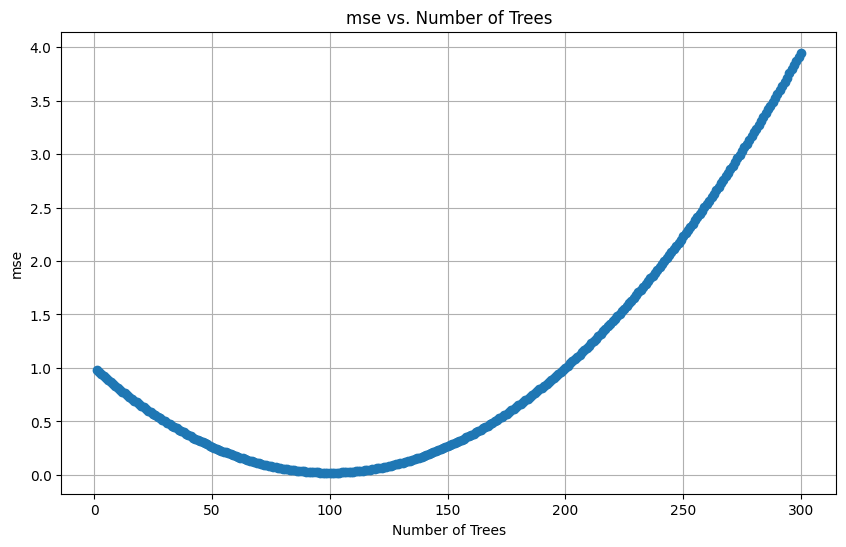

In [732]:

# storing the information of the classifiers in arrays the split value and the dimension chosen for the decision stumps 
dimension_chosen_array = []  ; split_chosen_array = [] ; left_val_array = [] ; right_val_array = [] ; min_mse_array = [] ; mse_list = []
# print(weights)

def calculate_loss_function(x_train_set, y_train_set , dimension, split_value, sorted_indices, indx):
   
    class1 = y_train_set[:indx]  ; class2 = y_train_set[indx:]
    
    mean_1 = np.mean(class1) 
    mean_2 = np.mean(class2)

    
    ssr_class1 = np.sum((class1 - mean_1) ** 2)
    ssr_class2 = np.sum((class2 - mean_2) ** 2) 
    total_ssr = ssr_class1 + ssr_class2 

    return total_ssr , mean_1 , mean_2 


  




  
def minimum_each_dimension(x_train_set, y_train_set , dimension):
  unique_values = unique_Values[dimension]
  
  # unique_values = np.random.choice(unique_values , size=1000 , replace=False)
  
#   unique_values = np.unique(x_train_set[:, dimension])
#   # for x in x_train_set:
#   #   if (x[dimension] not in unique_values):
#   #     unique_values.append(x[dimension])
  
#   unique_values = sorted(unique_values) 
  sorted_indices = np.argsort(x_train_set[:, dimension])
  # print(sorted_indices)
  x_train_set_sorted = x_train_set[sorted_indices]
  y_train_set_sorted = y_train_set[sorted_indices]
  

  min_mse = 10**19 
  split_val = 0   
  decided_mean_left = 0 
  decided_mean_right = 0 
  
  midpoints = (unique_values[1:] + unique_values[:-1]) /2 
  for i in range(1,len(midpoints) ):
    split_value = midpoints[i]
    # print("h1 : "+ str(split_value))
    min_mse_new , decided_mean_left_new , decided_mean_right_new = calculate_loss_function(x_train_set_sorted , y_train_set_sorted  , dimension , split_value ,sorted_indices , i)

    if (min_mse > min_mse_new):
      split_val = split_value 
      min_mse = min_mse_new  
      decided_mean_left = decided_mean_left_new  
      decided_mean_right = decided_mean_right_new 
  
  return min_mse , split_val , decided_mean_left , decided_mean_right

  
def best_dimension_and_split(x_train_set, y_train_set ):
  min_mse = 10**19 ; split_val = 0 ; selected_dimension = -1 ; wrongly_classified_points = [] ; decided_mean_left =0 ; decided_mean_right = 0
  # print(len(x_train_set))
  for x in range(len(x_train_set[1])):
    
    min_mse_new , split_value  , decided_mean_left_new ,decided_mean_right_new = minimum_each_dimension(x_train_set  , y_train_set , x) 
    if (min_mse > min_mse_new):
      min_mse = min_mse_new 
      split_val = split_value 
      selected_dimension = x
      decided_mean_left = decided_mean_left_new 
      decided_mean_right = decided_mean_right_new 
    # print(loss_value , split_value , wrongly_classified_points) 

  # print(len(wrongly_classified_points))
  return selected_dimension , split_val , min_mse , decided_mean_left , decided_mean_right

def change_labels(sorted_x_train_set , sorted_y_train_set , split_val , decided_mean_left , decided_mean_right):
  indices_to_include = sorted_x_train_set <= split_val  
  y_left = sorted_y_train_set[indices_to_include]
  indices_to_include = sorted_x_train_set > split_val  
  y_right = sorted_y_train_set[indices_to_include] 

  y_left_labels = np.where(y_left - 0.01*decided_mean_left < 0 , -1 ,1) 
  y_right_labels = np.where(y_right - 0.01*decided_mean_right < 0 , -1 ,1) 

  concatenated_labels = np.concatenate((y_left_labels, y_right_labels))

  return concatenated_labels 

  

def find_mse(indx , x_set , y_set):

  total_ssr = 0
  for i in range(len(x_set)):
    count1 = 0 
    for j in range(0 , indx+1):
      if (x_set[i][dimension_chosen_array[j]] < split_chosen_array[j]):
        count1 += (0.01 * left_val_array[j]) 
      else:
        count1 += (0.01 * right_val_array[j]) 
    

    total_ssr += (count1 - y_set[i]) ** 2
  
  return total_ssr / (len(x_set)) 


max_value_trees = -1 
min_mse_stored = 10**19 
# now let me create the h1(x) from the information provided by the above functions , it is just conditionals . 
def create_classifiers(x_train_set , y_train_set , num_of_classifiers , max_value_trees , min_mse_stored ):

  for num in range(0 , num_of_classifiers):
    selected_dimension , split_val , min_mse  , decided_mean_left , decided_mean_right = best_dimension_and_split(x_train_set , y_train_set ) 

    dimension_chosen_array.append(selected_dimension)
    split_chosen_array.append(split_val)
    left_val_array.append(decided_mean_left) 
    right_val_array.append(decided_mean_right)
    print(min_mse)
    min_mse_array.append(min_mse)

    sorted_x_indices = np.argsort(x_train_set[:,selected_dimension])
    sorted_x_train_set = x_train_set[sorted_x_indices , selected_dimension] 
    sorted_y_train_set = y_train_set[sorted_x_indices]

    new_labels = change_labels(sorted_x_train_set , sorted_y_train_set , split_val , decided_mean_left , decided_mean_right)  

    old_indx = np.argsort(sorted_x_indices)
    y_train_set = new_labels[old_indx]

  
    
    print("dimension: " + str(dimension_chosen_array))
    print("split: " + str(split_chosen_array))
    
    print("mse: " + str(min_mse_array))
    print("left: " + str(left_val_array))
    print("right: " + str(right_val_array))

    mse = find_mse(num , x_val_set , y_val_set) 
    mse_list.append(mse)  

    print("this is the mse on val set " + str(mse))
    # accuracy = find_accuracy(num , x_val_set , y_val_set)
    
    print(y_train_set)
    
    # accuracy_list.append(accuracy)

    if (min_mse_stored >= mse):
      min_mse_stored = mse 
      max_value_trees = num 

    
  
  num_trees = range(1, len(mse_list) + 1)

  plt.figure(figsize=(10, 6))
  plt.plot(num_trees, mse_list, marker='o')
  plt.xlabel('Number of Trees')
  plt.ylabel('mse')
  plt.title('mse vs. Number of Trees')
  plt.grid(True)
  plt.show()

  # # now ,lets test the accuracy on the test set . 
  # print(max_accuracy) 
  # print(max_value_trees)

  return min_mse_stored , max_value_trees 


# print(len(x_train_set))
# print(minimum_each_dimension(x_train_set , y_train_set , weights , 0))
# print(x_train_set.shape)
# print(best_dimension_and_split(x_train_set , y_train_set , weights))
min_mse_stored , max_value_trees = (create_classifiers(x_train_set , y_train_set , 300 , max_value_trees , max_accuracy))
# def find_best_split(x_train_set , y_train_set , weights):

In [733]:
print(min_mse_stored) 
print(max_value_trees)
test_mse = find_mse(max_value_trees , x_test , y_test)

print("The mse for the test set is :" + str(test_mse)) 

0.019900585926100615
99
The mse for the test set is :0.015078153450169073


199.06068291042573
dimension: [0]
split: [(192.72278407732898+0j)]
mse: [199.06068291042573]
left: [-0.9910514541387024]
right: [0.9902574808629089]
this is the mse on val set 0.9804831811866314
[ 1  1  1 ...  1 -1  1]
199.06068291042573
dimension: [0, 0]
split: [(192.72278407732898+0j), (192.72278407732898+0j)]
mse: [199.06068291042573, 199.06068291042573]
left: [-0.9910514541387024, -0.9910514541387024]
right: [0.9902574808629089, 0.9902574808629089]
this is the mse on val set 0.9611626416596328
[ 1  1  1 ...  1 -1  1]
199.06068291042573
dimension: [0, 0, 0]
split: [(192.72278407732898+0j), (192.72278407732898+0j), (192.72278407732898+0j)]
mse: [199.06068291042573, 199.06068291042573, 199.06068291042573]
left: [-0.9910514541387024, -0.9910514541387024, -0.9910514541387024]
right: [0.9902574808629089, 0.9902574808629089, 0.9902574808629089]
this is the mse on val set 0.9420383814188633
[ 1  1  1 ...  1 -1  1]
199.06068291042573
dimension: [0, 0, 0, 0]
split: [(192.72278407732898+0j), 

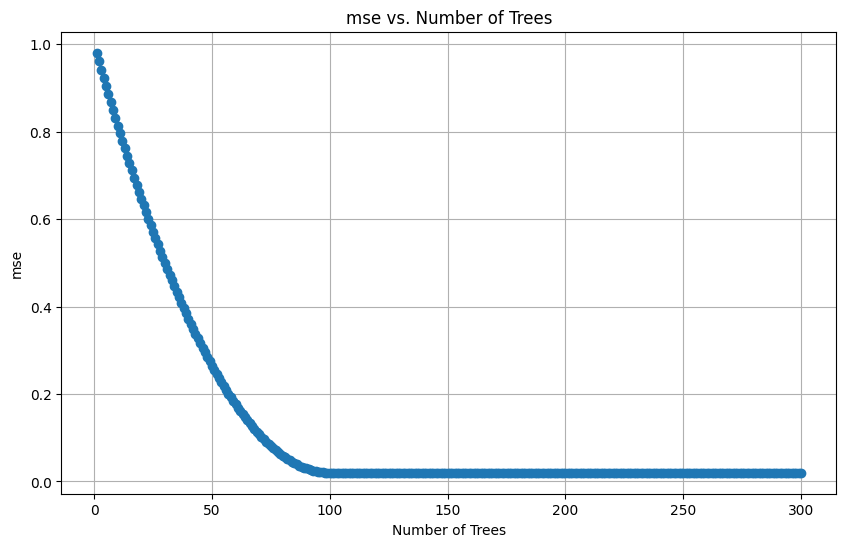

In [734]:

# storing the information of the classifiers in arrays the split value and the dimension chosen for the decision stumps 
dimension_chosen_array = []  ; split_chosen_array = [] ; left_val_array = [] ; right_val_array = [] ; min_mse_array = [] ; mse_list = [] ; residue = y_train_set 
# print(weights)

def calculate_loss_function(x_train_set, y_train_set , dimension, split_value, sorted_indices, indx):
   
    class1 = y_train_set[:indx]  ; class2 = y_train_set[indx:]
    
    mean_1 = np.mean(class1) 
    mean_2 = np.mean(class2)

    
    ssr_class1 = np.sum((class1 - mean_1) ** 2)
    ssr_class2 = np.sum((class2 - mean_2) ** 2) 
    total_ssr = ssr_class1 + ssr_class2 

    return total_ssr , mean_1 , mean_2 


  




  
def minimum_each_dimension(x_train_set, y_train_set , dimension):
  unique_values = unique_Values[dimension]
  
  # unique_values = np.random.choice(unique_values , size=1000 , replace=False)
  
#   unique_values = np.unique(x_train_set[:, dimension])
#   # for x in x_train_set:
#   #   if (x[dimension] not in unique_values):
#   #     unique_values.append(x[dimension])
  
#   unique_values = sorted(unique_values) 
  sorted_indices = np.argsort(x_train_set[:, dimension])
  # print(sorted_indices)
  x_train_set_sorted = x_train_set[sorted_indices]
  y_train_set_sorted = y_train_set[sorted_indices]
  

  min_mse = 10**19 
  split_val = 0   
  decided_mean_left = 0 
  decided_mean_right = 0 
  
  midpoints = (unique_values[1:] + unique_values[:-1]) /2 
  for i in range(1,len(midpoints) ):
    split_value = midpoints[i]
    # print("h1 : "+ str(split_value))
    min_mse_new , decided_mean_left_new , decided_mean_right_new = calculate_loss_function(x_train_set_sorted , y_train_set_sorted  , dimension , split_value ,sorted_indices , i)

    if (min_mse > min_mse_new):
      split_val = split_value 
      min_mse = min_mse_new  
      decided_mean_left = decided_mean_left_new  
      decided_mean_right = decided_mean_right_new 
  
  return min_mse , split_val , decided_mean_left , decided_mean_right

  
def best_dimension_and_split(x_train_set, y_train_set ):
  min_mse = 10**19 ; split_val = 0 ; selected_dimension = -1 ; wrongly_classified_points = [] ; decided_mean_left =0 ; decided_mean_right = 0
  # print(len(x_train_set))
  for x in range(len(x_train_set[1])):
    
    min_mse_new , split_value  , decided_mean_left_new ,decided_mean_right_new = minimum_each_dimension(x_train_set  , y_train_set , x) 
    if (min_mse > min_mse_new):
      min_mse = min_mse_new 
      split_val = split_value 
      selected_dimension = x
      decided_mean_left = decided_mean_left_new 
      decided_mean_right = decided_mean_right_new 
    # print(loss_value , split_value , wrongly_classified_points) 

  # print(len(wrongly_classified_points))
  return selected_dimension , split_val , min_mse , decided_mean_left , decided_mean_right

def change_labels(sorted_x_train_set , sorted_y_train_set , split_val , decided_mean_left , decided_mean_right , sorted_residues ):
  indices_to_include = sorted_x_train_set <= split_val  
  y_left = sorted_y_train_set[indices_to_include]
  indices_to_include = sorted_x_train_set > split_val  
  y_right = sorted_y_train_set[indices_to_include] 
  indices_to_include = sorted_x_train_set <= split_val   
  residues_left = sorted_residues[indices_to_include] 
  indices_to_include = sorted_x_train_set > split_val  
  residues_right = sorted_residues[indices_to_include]

  residues_left = residues_left - 0.01 * decided_mean_left 
  residues_right = residues_right - 0.01 * decided_mean_right 

  y_left_labels = np.where(residues_left < 0, -1, 1)
  y_right_labels = np.where(residues_right < 0, -1, 1)

  concatenated_labels = np.concatenate((y_left_labels, y_right_labels))
  residues = np.concatenate((residues_left , residues_right))

  return concatenated_labels ,residues

  

def find_mse(indx , x_set , y_set):

  total_ssr = 0
  for i in range(len(x_set)):
    count1 = 0 
    for j in range(0 , indx+1):
      if (x_set[i][dimension_chosen_array[j]] < split_chosen_array[j]):
        count1 += (0.01 * left_val_array[j]) 
      else:
        count1 += (0.01 * right_val_array[j]) 
    

    total_ssr += (count1 - y_set[i]) ** 2
  
  return total_ssr / (len(x_set)) 


max_value_trees = -1 
min_mse_stored = 10**19 
# now let me create the h1(x) from the information provided by the above functions , it is just conditionals . 
def create_classifiers(x_train_set , y_train_set , num_of_classifiers , max_value_trees , min_mse_stored ,residues):

  for num in range(0 , num_of_classifiers):
    selected_dimension , split_val , min_mse  , decided_mean_left , decided_mean_right = best_dimension_and_split(x_train_set , y_train_set ) 

    dimension_chosen_array.append(selected_dimension)
    split_chosen_array.append(split_val)
    left_val_array.append(decided_mean_left) 
    right_val_array.append(decided_mean_right)
    print(min_mse)
    min_mse_array.append(min_mse)

    sorted_x_indices = np.argsort(x_train_set[:,selected_dimension])
    sorted_x_train_set = x_train_set[sorted_x_indices , selected_dimension] 
    sorted_y_train_set = y_train_set[sorted_x_indices]
    sorted_residues = residues[sorted_x_indices] 

    new_labels , new_residues  = change_labels(sorted_x_train_set , sorted_y_train_set , split_val , decided_mean_left , decided_mean_right , sorted_residues)  

    old_indx = np.argsort(sorted_x_indices)
    y_train_set = new_labels[old_indx]
    residues = new_residues[old_indx] 

  
    
    print("dimension: " + str(dimension_chosen_array))
    print("split: " + str(split_chosen_array))
    
    print("mse: " + str(min_mse_array))
    print("left: " + str(left_val_array))
    print("right: " + str(right_val_array))

    mse = find_mse(num , x_val_set , y_val_set) 
    mse_list.append(mse)  

    print("this is the mse on val set " + str(mse))
    # accuracy = find_accuracy(num , x_val_set , y_val_set)
    
    print(y_train_set)
    
    # accuracy_list.append(accuracy)

    if (min_mse_stored >= mse):
      min_mse_stored = mse 
      max_value_trees = num 

    
  
  num_trees = range(1, len(mse_list) + 1)

  plt.figure(figsize=(10, 6))
  plt.plot(num_trees, mse_list, marker='o')
  plt.xlabel('Number of Trees')
  plt.ylabel('mse')
  plt.title('mse vs. Number of Trees')
  plt.grid(True)
  plt.show()

  # # now ,lets test the accuracy on the test set . 
  # print(max_accuracy) 
  # print(max_value_trees)

  return min_mse_stored , max_value_trees 


# print(len(x_train_set))
# print(minimum_each_dimension(x_train_set , y_train_set , weights , 0))
# print(x_train_set.shape)
# print(best_dimension_and_split(x_train_set , y_train_set , weights))
min_mse_stored , max_value_trees = (create_classifiers(x_train_set , y_train_set , 300 , max_value_trees , max_accuracy, residue))
# def find_best_split(x_train_set , y_train_set , weights):

In [735]:
print(min_mse_stored) 
print(max_value_trees)
test_mse = find_mse(max_value_trees , x_test , y_test)

print("The mse for the test set is :" + str(test_mse)) 

0.01990037655850082
103
The mse for the test set is :0.015041737329919654
